# Overview
In this notebook we explore the concept of Principal Component Analysis. This technique is a powerful tool which is typically used for dimentionality reduction. PCA will try to measure the importance of a feature by measuring the variance that the variable introduces into the system. We then minimize the number of factors selected while maximizing the amount of variance preserved by the selected factors.

Before reading this notebook ensure you are familiar with the material in the [README.md](README.md)

# Step 1. Load our data

In [2]:
# Load our libraires
import pandas
import numpy

In [3]:
# Load our sample data
import os
import pyprojroot
project_root_dir = pyprojroot.here()
input_file_path = os.path.join(project_root_dir, "Example Data Sets", "Test Scores.csv")
delimiter = ","
df = pandas.read_csv(input_file_path, delimiter=delimiter)
df

,ACT,FinalExam,QuizAvg,TestAvg
0,33,181,95,89
1,31,169,81,89
2,21,176,65,68
3,25,181,66,90
4,29,169,89,81
5,24,103,61,57
6,25,150,81,76
7,29,147,86,76
8,36,181,98,102
9,26,163,72,70


# Step 2. Decompose Eigenvalues and Eigenvectors

This step is the heart of PCA. In short, the eigenvalues/eigenvector decomposition provides us a a way of eliminating features which provide duplicate data.

Mathematically eigenvalues and eivenvectors allows us to selectively reduce the number of dimensions in our problem while minimizing (and thus quantifying) information loss. The information being considered in the case of PCA is that of the correlation matrix. Thus any redundancy is that of correlation. By reducing the dimensionality we are reducing the overall covariance explained by our feature set.

## 2.2. Using Scikit-learn To Calculate Eigenvalues

The python library scikit-learn provides an object named PCA which preforms the principal component analysis. The official documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009, depending on the shape of the input data and the number of components to extract.

**Note**: The data must be normalized before being passed to the PCA object in order to get the correct values.

In [41]:
normalized_df = ((df - df.mean())/df.std())

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(normalized_df)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

print(eigenvalues)
print("")
print(eigenvectors)
print("")

[2.97886743 0.76294635 0.17495639 0.08322983]

[[ 0.48865719  0.43504178  0.52153824  0.54767752]
 [-0.54890184  0.73529711 -0.33072051  0.22061023]
 [ 0.47319583 -0.11632092 -0.7729759   0.40627996]
 [ 0.48580512  0.50650396 -0.14536185 -0.69736436]]



## 2.2. Using Numpy To Calculate Eigenvalues

We can use a [builtin numpy function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) to do the eigen-decomposition. Note we can decompose either the covariance matrix or the correlation matrix.

### 2.2.1. Calculate Eigenvalues using Correlation Matrix

In [21]:
# Compute the correlation matrix (a numpy ndarray)
correlation_numpy_array = numpy.corrcoef(df.T)
correlation_numpy_array

# Do the decomposition
#
#    Note: The term right vector just refers to the orientation of rows vs columns
#          This is part of the math that we just do not need to worry about
#

eigenvalues_numpy_array, right_eigenvectors_numpy_array = numpy.linalg.eig(correlation_numpy_array)

# Look at our lamndas (eigenvalues)
eigenvalues_df = pandas.DataFrame(eigenvalues_numpy_array, index=df.columns, columns=["eigenvalue"])
eigenvalues_df

,eigenvalue
ACT,2.978867
FinalExam,0.762946
QuizAvg,0.083230
TestAvg,0.174956


### 2.3.2. Calculate Eigenvalues Using Covariance Matrix

In [22]:
# Compute the correlation matrix (a numpy ndarray)
covariance_numpy_array = numpy.corrcoef(df.T)
covariance_numpy_array

# Do the decomposition
#
#    Note: The term right vector just refers to the orientation of rows vs columns
#          This is part of the math that we just do not need to worry about
#

eigenvalues_numpy_array, right_eigenvectors_numpy_array = numpy.linalg.eig(covariance_numpy_array)

# Look at our lamndas (eigenvalues)
eigenvalues_df = pandas.DataFrame(eigenvalues_numpy_array, index=df.columns, columns=["eigenvalue"])
eigenvalues_df

,eigenvalue
ACT,2.978867
FinalExam,0.762946
QuizAvg,0.083230
TestAvg,0.174956


## 2.4. Calculate Proportion Of Variance Explained
If we look at the eigenvalues as being a measure of variance explained by a feature, we can cauluate the proportion of information explained by dividing the eigenvalue by the total sum of eigenvalues.

In [10]:
total_variance = eigenvalues_df["eigenvalue"].sum()
proportion_variance_explained_df = eigenvalues_df / total_variance
proportion_variance_explained_df = proportion_variance_explained_df.sort_values(by=["eigenvalue"], ascending=False)
proportion_variance_explained_df

,eigenvalue
ACT,0.744717
FinalExam,0.190737
TestAvg,0.043739
QuizAvg,0.020807


We can see that the proportions sum to 1. Note: Rounding errors are due to numpy's numerical implimentation of floating point numbers.

In [11]:
proportion_variance_explained_df["eigenvalue"].sum()

1.0000000000000002

# Step 3. Select the Principal Components
## 3.1. Frame the problem as an optimization problem
As with most problems, selecting the principal components is an optimization problem. If you are not familiar with optimization, see the [coresponding notebook](../Optimization/Optimization.ipynb).

We want to maximize the amount of variance explained or to minimize the information lost by removing a feature.

Looking at the proportion of information explained we see the following plot which can be optimized.

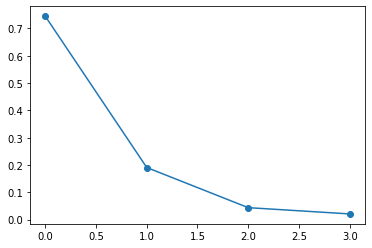

In [12]:
import matplotlib.pyplot as pyplot
fig, ax = pyplot.subplots()


x = []
y = []

for i, proportion in enumerate(proportion_variance_explained_df["eigenvalue"]):
    x.append(i)
    y.append(proportion)

ax.plot(x, y)
ax.scatter(x, y);

## 3.2. Select An Optimization Technique
As mentioned earlier, the [optimization notebook](../Optimization/Optimization.ipynb) discusses various methods for optimizing. In our case we need to select a cutoff point for an asymtotic function.

In our case we will choose to drop the last parameter with the smallest eigenvalue.